In [3]:
import scipy.io
seg_data = scipy.io.loadmat("C:\\Project Deep Learning\\data\\SUNRGBD\\kv1\\b3dodata\\img_0063\\seg.mat")
print(seg_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'seglabel', 'names'])


In [4]:
seg_data['names']

array([[array(['wall'], dtype='<U4'), array(['shelf'], dtype='<U5'),
        array(['shelf'], dtype='<U5'), array(['floor'], dtype='<U5'),
        array(['chair'], dtype='<U5'), array(['books'], dtype='<U5'),
        array(['books'], dtype='<U5'), array(['box'], dtype='<U3'),
        array(['books'], dtype='<U5')]], dtype=object)

Segmentation Mask Shape: (427, 561)


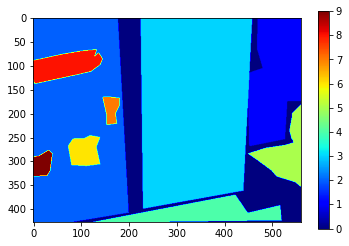

In [9]:
import scipy.io
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the .mat file
seg_data = scipy.io.loadmat("C:\\Project Deep Learning\\data\\SUNRGBD\\kv1\\b3dodata\\img_0063\\seg.mat")

# Extract the segmentation mask
seg_mask = seg_data["seglabel"]  # This is a 2D numpy array

# Print shape to check
print("Segmentation Mask Shape:", seg_mask.shape)

# Display the segmentation mask
plt.imshow(seg_mask, cmap="jet")
plt.colorbar()
plt.show()


In [10]:
import numpy as np

# Get unique class indices in the mask
unique_classes = np.unique(seg_mask)
print("Unique class indices in the mask:", unique_classes)


Unique class indices in the mask: [0 1 2 3 4 5 6 7 8 9]


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# Paths
rgb_dir = "C:/Project Deep Learning/data"
labels_dir = "C:/Project Deep Learning/data/labels_37"

# Read CSV files
train_df = pd.read_csv("C:/Project Deep Learning/data/splits/train_split.csv")
valid_df = pd.read_csv("C:/Project Deep Learning/data/splits/valid_split.csv")
test_df = pd.read_csv("C:/Project Deep Learning/data/splits/test_split.csv")

# Image size for DeepLabV3 (you can change it)
IMG_SIZE = (256, 256)

# Function to load and preprocess images
def load_image(img_path, label_path):
    # Read image
    img = tf.io.read_file(tf.strings.join([rgb_dir, "/", img_path]))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    
    # Normalize for DeepLabV3
    img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

    # Read label (segmentation mask)
    label = tf.io.read_file(tf.strings.join([labels_dir, "/", label_path]))
    label = tf.image.decode_png(label, channels=1)  # Ensure grayscale
    label = tf.image.resize(label, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Nearest neighbor resizing
    label = tf.cast(label, tf.int32)  # Convert to integer class indices
    
    return img, label

# Function to create a TensorFlow dataset
def create_dataset(df, batch_size=16, shuffle=True):
    img_paths = df.iloc[:, 0].values  # First column = RGB images
    label_paths = df.iloc[:, 1].values  # Second column = labels
    
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, label_paths))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create datasets
train_dataset = create_dataset(train_df)
valid_dataset = create_dataset(valid_df, shuffle=False)
test_dataset = create_dataset(test_df, shuffle=False)


In [5]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))>

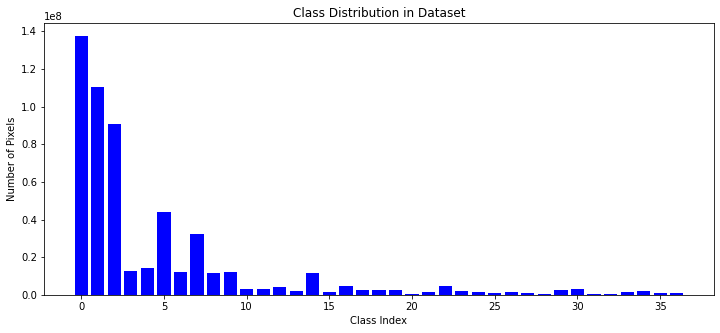

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to check class distribution in dataset
def check_class_distribution(dataset, num_classes=37):
    class_counts = np.zeros(num_classes)

    for _, label_batch in dataset:
        labels = label_batch.numpy().flatten()
        unique, counts = np.unique(labels, return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:  # Ensure valid class index
                class_counts[u] += c

    # Plot class distribution
    plt.figure(figsize=(12, 5))
    plt.bar(range(num_classes), class_counts, color='blue')
    plt.xlabel("Class Index")
    plt.ylabel("Number of Pixels")
    plt.title("Class Distribution in Dataset")
    plt.show()

# Run class distribution analysis
check_class_distribution(train_dataset)


In [18]:
expected_labels = set(range(37))  # Assuming labels should be from 0 to 36
unexpected_labels = set()  # Use a set to collect all unique unexpected labels

for _, label_batch in train_dataset:
    labels = label_batch.numpy().flatten()
    unique = np.unique(labels)
    batch_unexpected_labels = set(unique) - expected_labels
    if batch_unexpected_labels:
        unexpected_labels.update(batch_unexpected_labels)  # Add to the main set

print(f"Unexpected labels found in the dataset: {unexpected_labels}")

Unexpected labels found in the dataset: {37}


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Initialize a dictionary to store the count of each class
class_counts = {i: 0 for i in range(38)}

# Step 1: Count the occurrences of each class in the dataset
for _, label_batch in train_dataset:
    labels = label_batch.numpy().flatten()
    unique, counts = np.unique(labels, return_counts=True)
    for cls, cnt in zip(unique, counts):
        class_counts[cls] += cnt

# Step 2: Compute class weights
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / (len(class_counts) * cnt) for cls, cnt in class_counts.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 0.10368095290498432, 1: 0.1288833439564029, 2: 0.15689740056298793, 3: 1.1420302575955066, 4: 1.0204079308262362, 5: 0.32405283716483385, 6: 1.1713525323680567, 7: 0.44492180198567327, 8: 1.2456093593255504, 9: 1.1656493999891475, 10: 4.384419275338978, 11: 4.592979490512342, 12: 3.5159505509030358, 13: 7.649182360865487, 14: 1.223832885950388, 15: 8.677518327948755, 16: 2.915982566734064, 17: 6.015263324858445, 18: 5.663526764438516, 19: 5.6726043408979345, 20: 65.73962746242292, 21: 8.520510883781466, 22: 3.1986625693685884, 23: 7.105110762681788, 24: 8.211665837243203, 25: 15.774610282283879, 26: 8.594374846900525, 27: 16.773915425794883, 28: 80.79675603166788, 29: 5.080995119971509, 30: 4.998464239563352, 31: 30.914639681941615, 32: 43.206717980319134, 33: 10.786742577286471, 34: 7.49134661886008, 35: 12.799588789214788, 36: 15.537864788154037, 37: 12.038133919628033}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = np.arange(37)
class_weights = compute_class_weight("balanced", classes=class_indices, y=all_labels.flatten())

class_weight_dict = {i: w for i, w in enumerate(class_weights)}


In [ ]:
7

In [26]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,        # Rotate images by up to 20 degrees
#     width_shift_range=0.2,    # Shift width by 20%
#     height_shift_range=0.2,   # Shift height by 20%
#     horizontal_flip=True,     # Flip images horizontally
#     brightness_range=[0.8, 1.2],  # Random brightness changes
#     zoom_range=0.2            # Zoom in/out
# )

# # Underrepresented classes (highest class weights)
# underrepresented_classes = [20, 28, 31, 32, 25, 27, 36, 35, 37, 33]

# # Apply augmentation only to these classes
# for class_idx in underrepresented_classes:
#     # Filter images for the current class
#     class_images = []
#     for img, label in train_dataset:
#         # Check if the label matches the current class
#         if tf.reduce_all(tf.equal(label, class_idx)):  # Fix: Use tf.reduce_all
#             class_images.append(img)

#     # Augment images for the current class
#     for img in class_images:
#         augmented_images = datagen.flow(tf.expand_dims(img, axis=0), batch_size=1)
#         for i in range(5):  # Generate 5x more samples
#             augmented_image = next(augmented_images)[0]
#             # Add the augmented image and its label to the dataset
#             train_dataset = train_dataset.concatenate(
#                 tf.data.Dataset.from_tensor_slices((augmented_image, class_idx))
#             )

Class distribution before augmentation:


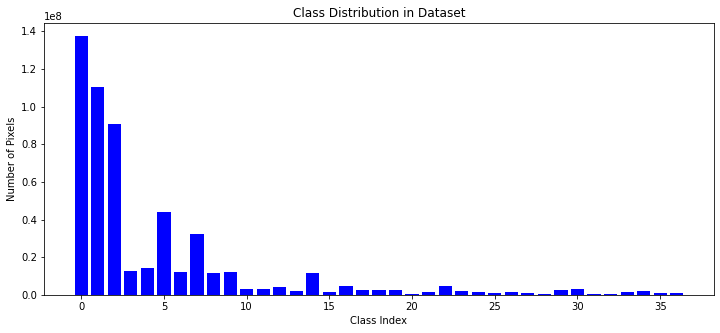

Class distribution after augmentation:


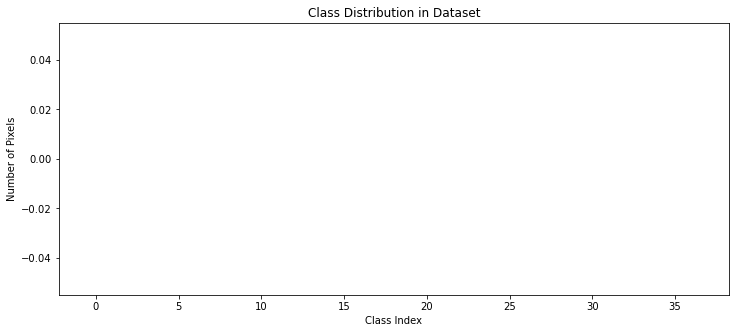

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Rotate images by up to 20 degrees
    width_shift_range=0.2,    # Shift width by 20%
    height_shift_range=0.2,   # Shift height by 20%
    horizontal_flip=True,     # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Random brightness changes
    zoom_range=0.2            # Zoom in/out
)

# Underrepresented classes (highest class weights)
underrepresented_classes = [20, 28, 31, 32, 25, 27, 36, 35, 37, 33]

# Function to check class distribution in dataset
def check_class_distribution(dataset, num_classes=37):
    class_counts = np.zeros(num_classes)

    for _, label_batch in dataset:
        labels = label_batch.numpy().flatten()
        unique, counts = np.unique(labels, return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:  # Ensure valid class index
                class_counts[u] += c

    # Plot class distribution
    plt.figure(figsize=(12, 5))
    plt.bar(range(num_classes), class_counts, color='blue')
    plt.xlabel("Class Index")
    plt.ylabel("Number of Pixels")
    plt.title("Class Distribution in Dataset")
    plt.show()

# Create lists to store images and labels
augmented_images = []
augmented_labels = []

# Apply augmentation only to these classes
for class_idx in underrepresented_classes:
    # Filter images for the current class
    class_images = []
    class_labels = []
    for img, label in train_dataset:
        if tf.reduce_all(tf.equal(label, class_idx)):  # Filter images by class
            class_images.append(img)
            class_labels.append(label)

    # Augment images for the current class
    for img, label in zip(class_images, class_labels):
        augmented_images_gen = datagen.flow(tf.expand_dims(img, axis=0), batch_size=1)

        for i in range(5):  # Generate 5x more samples
            augmented_image = next(augmented_images_gen)[0]
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

# Create a tf.data.Dataset from augmented images and labels
augmented_train_dataset = tf.data.Dataset.from_tensor_slices((np.array(augmented_images), np.array(augmented_labels)))

# Check class distribution before and after augmentation
print("Class distribution before augmentation:")
check_class_distribution(train_dataset)

print("Class distribution after augmentation:")
check_class_distribution(augmented_train_dataset)


In [ ]:
7

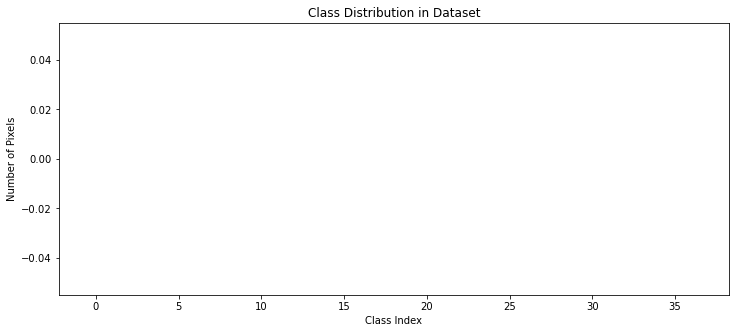

In [37]:
check_class_distribution(augmented_train_dataset)

In [ ]:
for img, label in train_dataset.take(1):  # Inspect the first batch
    print("Image shape:", img.shape)
    print("Label shape:", label.shape)
    print("Label value:", label.numpy())

In [41]:
unique_labels = set()

for _, label_batch in train_dataset:
    labels = label_batch.numpy().flatten()
    unique_labels.update(labels)

print("Unique labels in dataset:", unique_labels)


Unique labels in dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


In [ ]:
7

In [ ]:
class_counts_after = {}

# Count occurrences of each class after augmentation
for img, label in train_dataset:
    class_counts_after[label.numpy()] = class_counts_after.get(label.numpy(), 0) + 1

print("Class counts after augmentation:", class_counts_after)


In [ ]:
# Compute class weights based on dataset
from sklearn.utils.class_weight import compute_class_weight

# Get all class labels from dataset
all_labels = []
for _, label_batch in train_dataset:
    labels = label_batch.numpy().flatten()
    all_labels.extend(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.arange(NUM_CLASSES), 
                                     y=all_labels)
class_weights = {i: w for i, w in enumerate(class_weights)}

print("Class Weights:", class_weights)

# Use weighted loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
weighted_loss_fn = lambda y_true, y_pred: loss_fn(y_true, y_pred) * tf.gather(tf.constant(list(class_weights.values())), y_true)

# Recompile model with weighted loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=weighted_loss_fn,
              metrics=['accuracy'])


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load DeepLabV3+ model with MobileNetV2 backbone
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/deeplabv3/1", trainable=True)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy"])

# Train
model.fit(train_dataset, epochs=10, validation_data=val_dataset)
